### Trend Following Strategy

Trend Following 전략은 자산 가격이 일정 방향으로 움직이는 경향을 포착하여, 상승 추세일 때 매수하고 하락 추세일 때 매도하는 규칙 기반 투자 전략이다. 가격의 Momentum을 활용하여 수익을 추구하며, 일반적으로 Moving Average나 돌파 신호를 통해 진입과 청산을 결정한다. 금융 시장의 비효율성을 이용하여 중장기적인 수익을 목표로 하는 전략으로, 승률이 높은 편이다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
data = yf.download(
    'SPY',
    start = '1990-01-01',
    interval = '1d',
    multi_level_index = False,
    progress = False,
    auto_adjust = True
)

In [3]:
import datetime

def plot_candle_chart(data):
    up = data['Close'] > data['Open']  # 양봉 (상승)
    down = data['Close'] < data['Open']  # 음봉 (하락)
    fig, ax = plt.subplots(figsize = (8, 5))
    
    ax.vlines(data.index[up], data['Low'][up], data['High'][up], 
              color='tab:red', linewidth=0.5)
    ax.vlines(data.index[up], data['Open'][up], data['Close'][up], 
              color='tab:red', linewidth=2)
    
    ax.vlines(data.index[down], data['Low'][down], data['High'][down], 
              color='tab:blue', linewidth=0.5)
    ax.vlines(data.index[down], data['Open'][down], data['Close'][down], 
              color='tab:blue', linewidth=2)
    
    ax.plot(data['Close'].rolling(5).mean(), label = 'MA5')
    ax.plot(data['Close'].rolling(20).mean(), label = 'MA20')
    ax.plot(data['Close'].rolling(60).mean(), label = 'MA60')
    ax.legend()
    
    ax.plot(data['Close'].rolling(20).mean() + 2 * data['Close'].rolling(20).std(), color = 'k', alpha = 0.3, ls='-.')
    ax.plot(data['Close'].rolling(20).mean() - 2 * data['Close'].rolling(20).std(), color = 'k', alpha = 0.3, ls='-.')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')    
    
    plt.xlim(
        datetime.datetime(2024, 9, 30),
        datetime.datetime(2025, 6, 30)
    )
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)
    ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
    return fig, ax

#### 1. Moving Average

Trend Following 전략 중 가장 일반적인 전략으로, 보통 단기선이 장기선을 상향돌파할 때를 매수 신호로 잡는다. `pandas.Series`혹은 `pandas.DataFrame`에서 `rolling()` method를 사용하면 이동평균을 계산할 수 있다. 이동평균선은 너무 유명한 보조 지표이기 때문에 각 기간별로 별명이 존재한다.

- 5일선 : 생명선
- 20일선 : 세력선
- 60일선 : 수급선
- 120일선 : 경기선


In [4]:
ma5 = data['Close'].rolling(5).mean() # moving average,
ma20 = data['Close'].rolling(20).mean()
ma60 = data['Close'].rolling(60).mean()

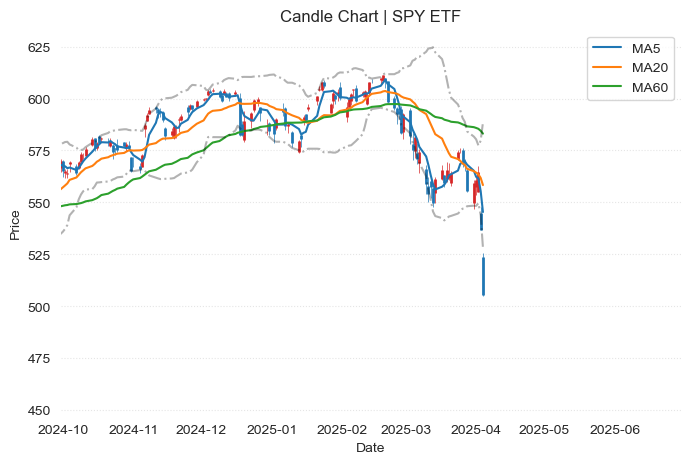

In [5]:
fig, ax = plot_candle_chart(data.loc['2024':])
plt.title('Candle Chart | SPY ETF')
plt.show()

signal은 조건문의 중복을 통해 생성할 수 있다.

In [6]:
buy_signal = (ma5 >= ma20) & (ma5.shift(1) < ma20.shift(1)) # 전날에 비해 상향돌파
sell_signal = (ma5 < ma20) & (ma5.shift(1) >= ma20.shift(1)) # 전날에 비해 하향돌파

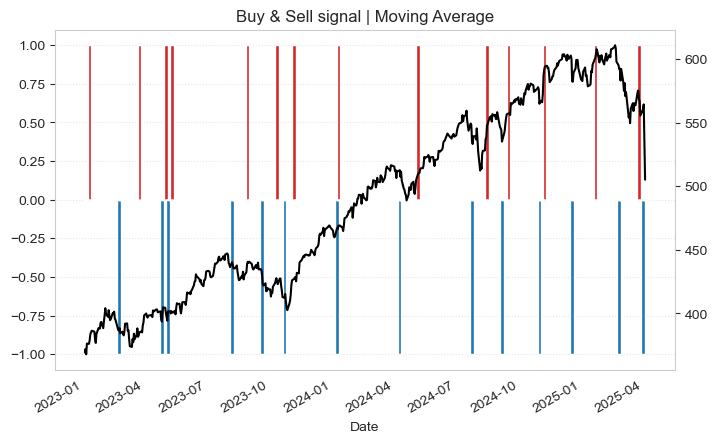

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.bar(buy_signal.astype(int).loc['2023':].index, buy_signal.astype(int).loc['2023':], width = 5, color = 'tab:red')
ax.bar(buy_signal.astype(int).loc['2023':].index, sell_signal.astype(int).loc['2023':] * -1, width = 5, color = 'tab:blue')

data.loc['2023':,'Close'].plot(secondary_y=True, color = 'black', ax = ax)

for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Buy & Sell signal | Moving Average')
plt.show()

moving average전략은 직관적이고 이해가 쉽다는 장점이 있지만, 신호가 늦게 뜬다는 치명적인 단점이 존재했다. 이를 보완하기 위해, 산술 평균을 지수가중 이동평균으로 바꾼 EWMA를 사용하기도 한다. EWMA는 `pandas.Sereis()` 혹은 `pandas.DataFrame()`에서 `ewm()` method를 통해 구현 가능하다

In [23]:
ma5 = data['Close'].ewm(5).mean() # moving average,
ma20 = data['Close'].ewm(20).mean()
ma60 = data['Close'].ewm(60).mean()

In [24]:
buy_signal = (ma5 >= ma20) & (ma5.shift(1) < ma20.shift(1)) # 전날에 비해 상향돌파
sell_signal = (ma5 < ma20) & (ma5.shift(1) >= ma20.shift(1)) # 전날에 비해 하향돌파

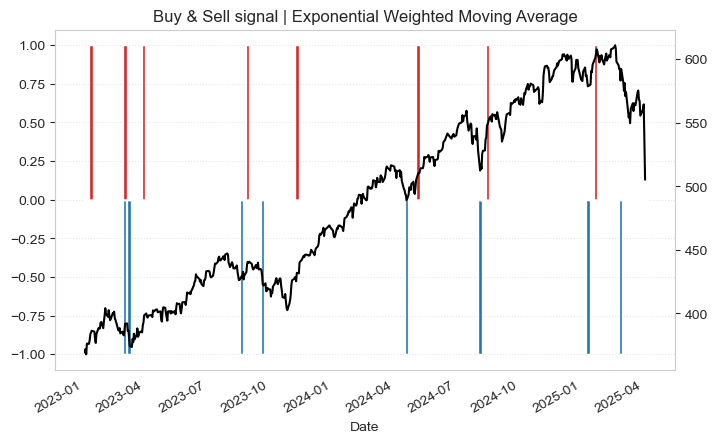

In [25]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.bar(buy_signal.astype(int).loc['2023':].index, buy_signal.astype(int).loc['2023':], width = 5, color = 'tab:red')
ax.bar(buy_signal.astype(int).loc['2023':].index, sell_signal.astype(int).loc['2023':] * -1, width = 5, color = 'tab:blue')

data.loc['2023':,'Close'].plot(secondary_y=True, color = 'black', ax = ax)

for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Buy & Sell signal | Exponential Weighted Moving Average')
plt.show()

EWMA를 이용해 Moving average 전략을 구축하는 경우, False Alarm문제를 어느정도 줄일 수 있다는 것이 장점이다.

#### 2. Aroon Indicator

Aroon Indicator는 가격 변동 추세의 강도와 방향을 파악하기 위한 지표이다. Aroon Up은 최근 최고가가 얼마나 가까운지, Aroon Down은 최근 최저가가 얼마나 가까운지를 나타낸다. 

Aroon Up이 Aroon Down을 상향 돌파하면 매수 신호로 해석한다.

In [33]:
aroon_up = 100 * (25 - data['High'].rolling(window=25).apply(lambda x: x[::-1].argmax())) / 25
aroon_down = 100 * (25 - data['Low'].rolling(window=25).apply(lambda x: x[::-1].argmin())) / 25

aroon = aroon_up - aroon_down
aroon_buy = (aroon >= 0) & (aroon.shift(1) < 0)
aroon_sell = (aroon < 0) & (aroon.shift(1) >= 0)

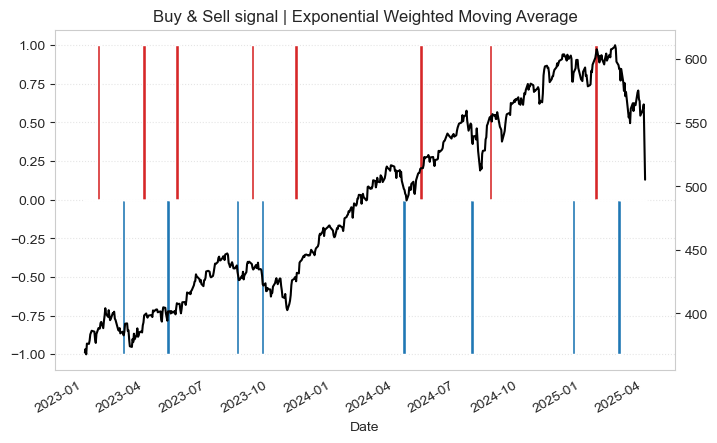

In [37]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.bar(aroon_buy.astype(int).loc['2023':].index, aroon_buy.astype(int).loc['2023':], width = 5, color = 'tab:red')
ax.bar(aroon_sell.astype(int).loc['2023':].index, aroon_sell.astype(int).loc['2023':] * -1, width = 5, color = 'tab:blue')

data.loc['2023':,'Close'].plot(secondary_y=True, color = 'black', ax = ax)

for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Buy & Sell signal | Exponential Weighted Moving Average')
plt.show()